### Kuramoto Model

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/Documentos/StuartLandauWBM/")

In [10]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc
from hoi.core import get_mi
from plot import circular_hist
from tqdm import tqdm

from src.models import simulate_hopf, simulate_delayed

In [3]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [4]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def return_unique_terms(data, stim, shuffle=False):

    x = data.sel(roi="x") * np.conj(data.sel(roi="y"))

    if shuffle:
        x = shuffle_along_axis(x.data, 0)

    R1 = np.asarray((x * np.conj(x)).real)
    R2 = np.unwrap(np.angle(x))

    # Stims across trials
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (data.sizes["times"], 1)).squeeze().T

    I_S_12 = gccmi_nd_ccc(R1, R2, stim, traxis=0)
    I_S_1 = gcmi_nd_cc(stim, R1, traxis=0)
    I_S_2 = gcmi_nd_cc(stim, R2, traxis=0)
    R_12 = np.minimum(I_S_1, I_S_2)

    if shuffle:
        return np.maximum(I_S_1, I_S_2)
    return I_S_1 - R_12, I_S_2 - R_12

#### Simulation (no-delays) 

In [5]:
ntrials = 500
C = np.array([[0, 1, 0], [0, 0, 1], [0, 0, 0]]).T

decim = 5
fsamp = 1 / 1e-4
beta = 1e-4
f = 40
a = -5
s = 32 / (2 * np.pi * f)

time = np.arange(-1, 3, 1 / fsamp)
Npoints = len(time)

time_start = 2
time_end = 3.0
g = 1

timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = jnp.exp(-(timestim**2) / (2 * s**2))
coupling = jnp.zeros_like(time)
coupling = coupling.at[ind].set(coupling[ind] + gaussian)

In [6]:
C.T

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 0]])

In [7]:
simulate_jax = jax.vmap(
    simulate_hopf,
    in_axes=(None, 0, None, None, None, None, None, 0, None, None),
)

In [8]:
Iext = np.zeros(Npoints)
Iext[(time >= 2) & (time <= 2.5)] = 1
Amplitudes = np.linspace(1, 100, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.arange(0, ntrials)

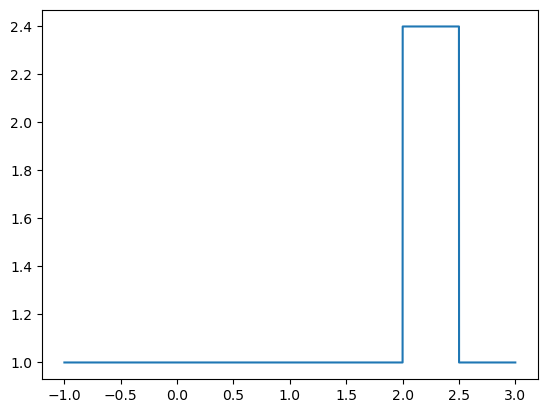

In [9]:
plt.plot(time, CS[2].squeeze() + 1)

In [21]:
data_amp = np.stack(
    simulate_jax(
        g * C,
        CS.squeeze(),
        f,
        a,
        fsamp,
        beta,
        Npoints,
        seeds,
        "cpu",
        decim,
    )
)
data_amp = data_amp.squeeze()

In [22]:
data_amp.shape

(500, 3, 8000)

In [23]:
data = xr.DataArray(
    data_amp,
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, ["x", "y", "z"], time[::decim]),
)

In [24]:
uamp1, uphase1 = return_unique_terms(data, Amplitudes)
__iter = tqdm(range(20))
uc1 = [return_unique_terms(data, Amplitudes, True) for i in __iter]

100%|████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.84s/it]


Text(0.5, 0, 'time [s]')

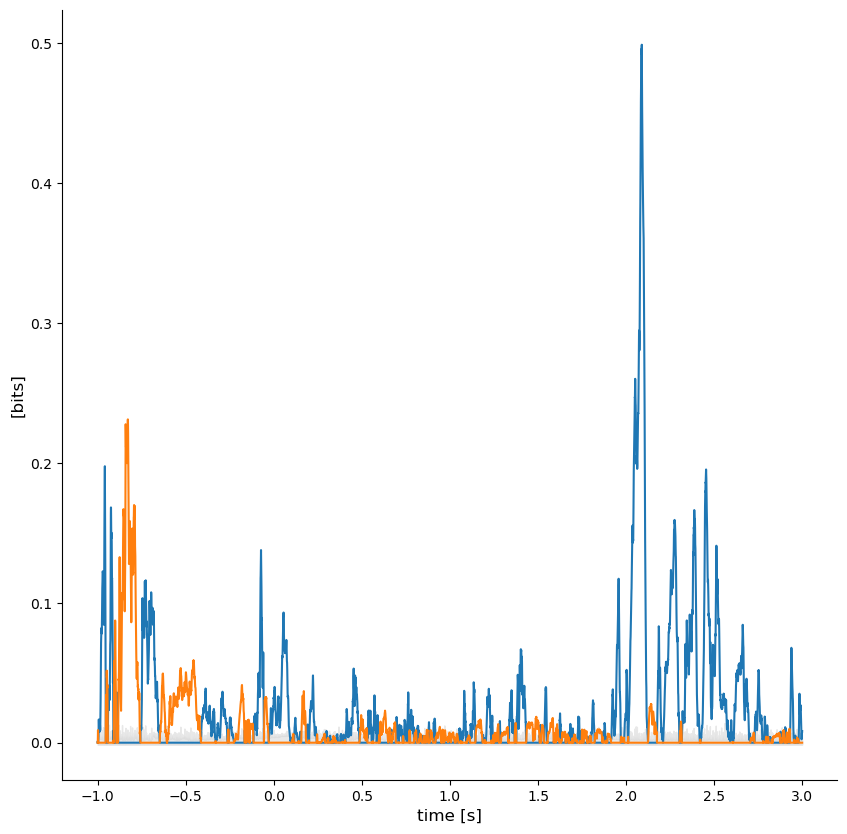

In [26]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
plt.plot(time[::decim], uamp1)
plt.plot(time[::decim], uphase1)
# plt.plot(time, CS[0, 0] / 10, c="k")

plt.fill_between(
    time[::decim],
    np.quantile(uc1, 0.05, axis=0),
    np.quantile(uc1, 0.95, axis=0),
    color="lightgray",
    alpha=0.5,
)

[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)

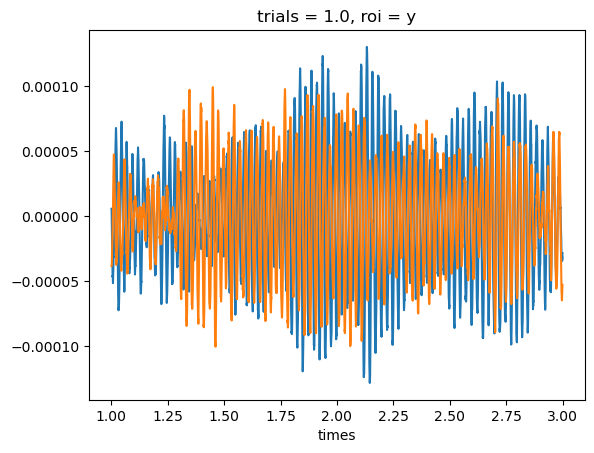

In [27]:
data[0, 0].real.sel(times=slice(1, 4)).plot()
data[0, 1].real.sel(times=slice(1, 4)).plot()

In [16]:
from mne.time_frequency import tfr_array_morlet

### Decompose in time-frequency domain

freqs = np.linspace(20, 60, 60)

S = tfr_array_morlet(
    data.values,
    fsamp / decim,
    freqs,
    freqs / 4,
    output="complex",
    n_jobs=1,
    zero_mean=False,
)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values},
)

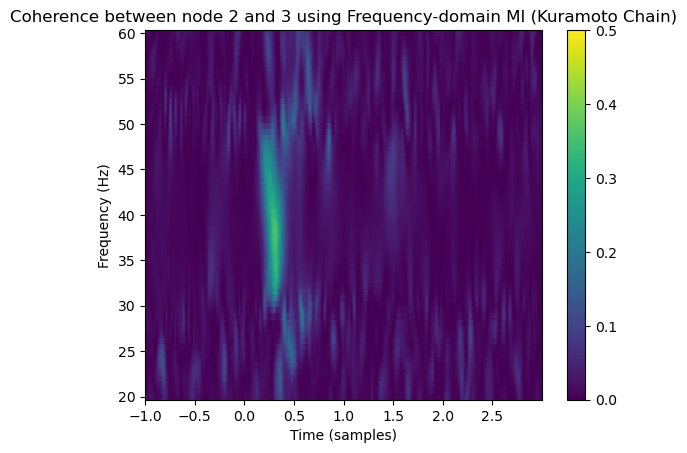

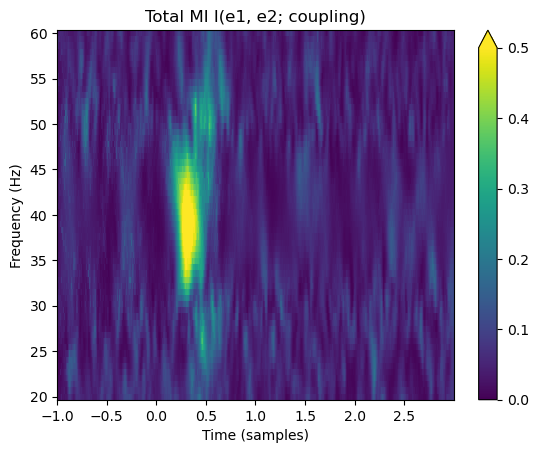

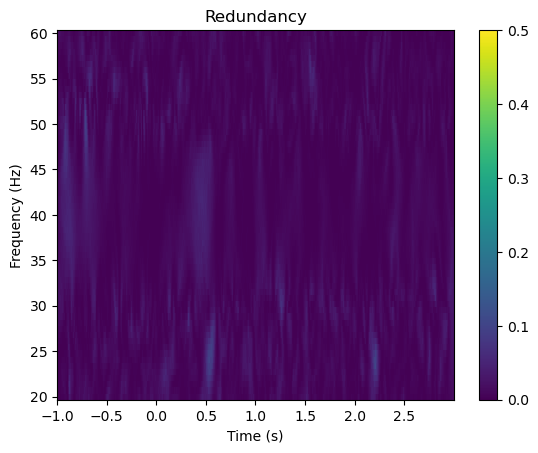

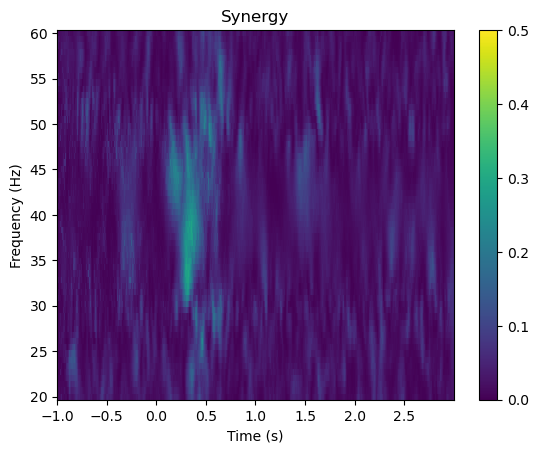

In [17]:
### Compute phase and amplitude terms

# Define the function to compute MI using HOI and JAX
mi_fcn = get_mi("gc")

# vectorize the function to first and second dimension
gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

# Select data for nodes
x = S.sel(roi=[0]).data.squeeze()
y = S.sel(roi=[1]).data.squeeze()
z = S.sel(roi=[2]).data.squeeze()

# Edge activity (with and without normalisation)
e1 = x * np.conj(y)
e2 = y * np.conj(z)
e3 = x * np.conj(z)

# Real and Imag parts pf edge activity
e1r, e1i = np.real(e1), np.imag(e1)
e2r, e2i = np.real(e2), np.imag(e2)
e3r, e3i = np.real(e3), np.imag(e3)

# Stack complex values
E1 = np.stack((e1r, e1i), axis=1)
E2 = np.stack((e2r, e2i), axis=1)
E3 = np.stack((e3r, e3i), axis=1)
E12 = np.stack((e1r, e1i, e2r, e2i), axis=1)
E23 = np.stack((e2r, e2i, e3r, e3i), axis=1)
E123 = np.stack((e1r, e1i, e2r, e2i, e3r, e3i), axis=1)

# Swap axis 0 with 3 and 1 with 2
E1 = np.moveaxis(E1, [0, 1], [-1, -2])
E2 = np.moveaxis(E2, [0, 1], [-1, -2])
E3 = np.moveaxis(E3, [0, 1], [-1, -2])
E12 = np.moveaxis(E12, [0, 1], [-1, -2])
E23 = np.moveaxis(E23, [0, 1], [-1, -2])
E123 = np.moveaxis(E123, [0, 1], [-1, -2])

# Stims across trials
stim = data.trials.values
stim = np.expand_dims(stim, axis=(0, 1))
stim = np.tile(stim, (len(freqs), data.sizes["times"], 1, 1))

# # MI frequency domain
# mi_freq[i, :] = gcmi_nd_cc(X, Y, mvaxis=1, traxis=0)

# # Coherence
# coh[i, :] = np.abs(e1.mean(axis=0)).squeeze()

# # Phase-Locking Value
# plv[i, :] = np.abs(e1n.mean(axis=0)).squeeze()

# Copnorm
E1 = copnorm_nd(E1, axis=-1)
E2 = copnorm_nd(E2, axis=-1)
E3 = copnorm_nd(E3, axis=-1)
E12 = copnorm_nd(E12, axis=-1)
E23 = copnorm_nd(E23, axis=-1)
E123 = copnorm_nd(E123, axis=-1)
stim = copnorm_nd(stim, axis=-1)

# MIF for edge encoding
mif_e1 = gcmi(E1, stim).T
mif_e2 = gcmi(E2, stim).T
mif_e3 = gcmi(E3, stim).T
mif_e12 = gcmi(E12, stim).T
mif_e23 = gcmi(E23, stim).T
mif_e123 = gcmi(E123, stim).T

red = np.minimum(mif_e1, mif_e2)

syn = mif_e123 - np.maximum(mif_e1, mif_e2)

## Plot

times = data.times.values
ax = plt.subplot()
# Plot single-trial and time-frequency MI
mi = xr.DataArray(mif_e3, dims=("times", "freqs"), coords=(times, freqs))
# Plot trial-average time-frequency MI
mi.plot(x="times", y="freqs", cmap="viridis", vmin=0, vmax=0.5)
# mi.plot.title('ciao')
ax.set_title(
    "Coherence between node 2 and 3 using Frequency-domain MI (Kuramoto Chain)"
)
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

ax = plt.subplot()
# Plot single-trial and time-frequency MI
mi = xr.DataArray(mif_e123, dims=("times", "freqs"), coords=(times, freqs))
# Plot trial-average time-frequency MI
mi.plot(x="times", y="freqs", cmap="viridis", vmin=0, vmax=0.5)
# mi.plot.title('ciao')
ax.set_title("Total MI I(e1, e2; coupling)")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

ax = plt.subplot()
# Plot single-trial and time-frequency MI
mi = xr.DataArray(red, dims=("times", "freqs"), coords=(times, freqs))
# Plot trial-average time-frequency MI
mi.plot(x="times", y="freqs", cmap="viridis", vmin=0, vmax=0.5)
# mi.plot.title('ciao')
ax.set_title("Redundancy")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

ax = plt.subplot()
# Plot single-trial and time-frequency MI
mi = xr.DataArray(syn, dims=("times", "freqs"), coords=(times, freqs))
# Plot trial-average time-frequency MI
mi.plot(x="times", y="freqs", cmap="viridis", vmin=0, vmax=0.5)
# mi.plot.title('ciao')
ax.set_title("Synergy")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

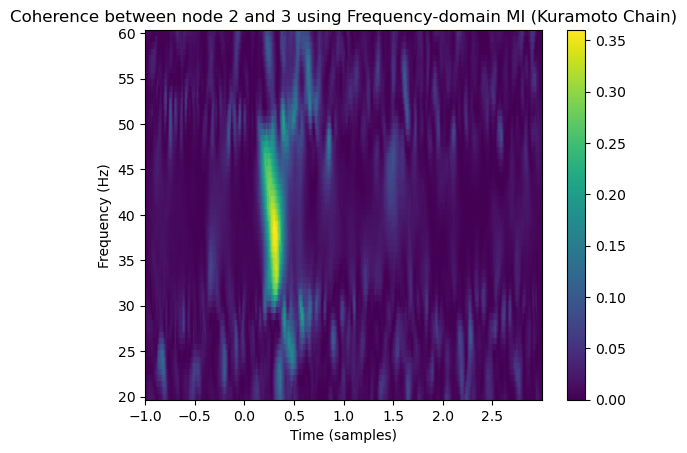

In [18]:
times = data.times.values
ax = plt.subplot()
# Plot single-trial and time-frequency MI
mi = xr.DataArray(mif_e3, dims=("times", "freqs"), coords=(times, freqs))
# Plot trial-average time-frequency MI
mi.plot(x="times", y="freqs", cmap="viridis", vmin=0)
# mi.plot.title('ciao')
ax.set_title(
    "Coherence between node 2 and 3 using Frequency-domain MI (Kuramoto Chain)"
)
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

In [30]:
z = (data.real - data.real.mean("times")) / data.real.std("times")

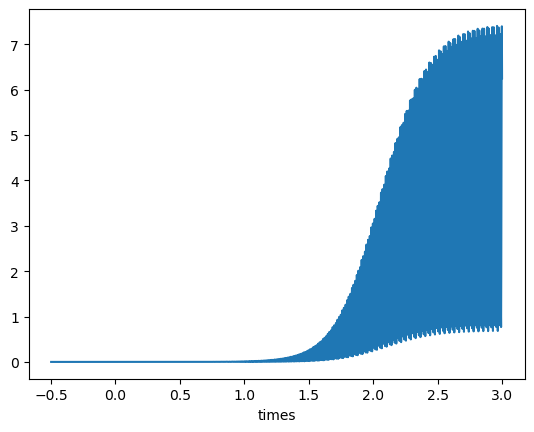

In [31]:
(z[:, 0] * z[:, 2]).mean("trials").sel(times=slice(-0.5, 3)).plot()

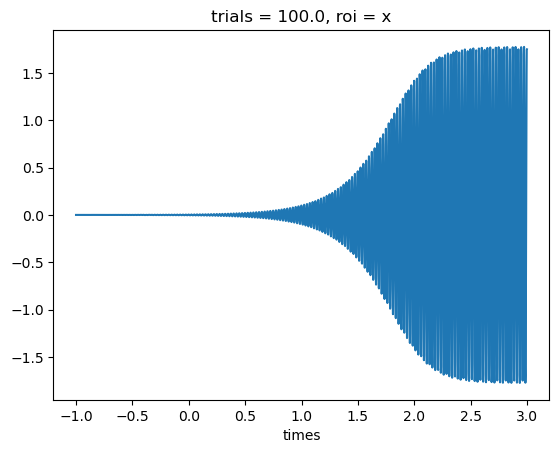

In [33]:
data[-1, 0].real.plot()

In [8]:
ntrials = 500
C = np.array([[0, 1], [0, 0]]).T

decim = 5
fsamp = 1 / 1e-4
beta = 1e-4
f = 40
g = np.linspace(1, 10, 30)
a = np.linspace(-5, 2, 30)

simulate_jax = jax.vmap(
    simulate_hopf,
    in_axes=(None, 0, None, 0, None, None, None, None, None, None),
)

simulate_hopf(
    C,
    1,
    f,
    -5,
    fsamp,
    beta,
    Npoints,
    2837932,
    "cpu",
    decim,
)

[1. 1.]


Array([[ 1.14681783e-04-4.53400608e-06j,  1.12574004e-04+1.02412666e-05j,
         1.10315335e-04+2.57597201e-05j, ...,
         4.12077608e-05-4.90429771e-05j,  4.40088826e-05-4.32966721e-05j,
         4.97698763e-05-3.97381527e-05j],
       [-1.62853466e-04+6.13637510e-05j, -1.71172160e-04+3.83824709e-05j,
        -1.76025468e-04+2.25767700e-05j, ...,
        -2.44031860e-05+2.57582708e-05j, -3.05817752e-05+2.48618750e-05j,
        -3.00894561e-05+1.85027430e-05j]], dtype=complex128)